In [18]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.optimizers import Adadelta
from keras.utils import plot_model
from keras import initializers
from __future__ import division

import pydot
import graphviz
import numpy as np

import h5py as h5py

import matplotlib.pyplot as plt


### Parameters

In [3]:
#Parameters for the training updates
img_width, img_height = 400, 250
nb_train_samples = 3000 #1184 unique pics
nb_validation_samples = 400 #90 unique pics 
batch_size = 32
epochs = 400

label_mode="binary"

train_data_dir="../PICS/train"
validation_data_dir="../PICS/val"

### Inception v3 model setup
Keep bottom layers of the the inception v3 model and train last fully connected layers with new data.

In [4]:
base_model = InceptionV3(weights='imagenet',include_top=False,input_shape = (img_height, img_width, 3))

In [5]:
base_model.summary() #Prints the architecture of the model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 250, 400, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 124, 199, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 124, 199, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 124, 199, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

____________________________________________________________________________________________________
mixed8 (Concatenate)             (None, 6, 11, 1280)   0           activation_72[0][0]              
                                                                   activation_76[0][0]              
                                                                   max_pooling2d_4[0][0]            
____________________________________________________________________________________________________
conv2d_81 (Conv2D)               (None, 6, 11, 448)    573440      mixed8[0][0]                     
____________________________________________________________________________________________________
batch_normalization_81 (BatchNor (None, 6, 11, 448)    1344        conv2d_81[0][0]                  
____________________________________________________________________________________________________
activation_81 (Activation)       (None, 6, 11, 448)    0           batch_normalization_81[0

#### Add new top layers
We add a pooling layer as well as 2 FC layers. Binary Output.
Optimization is done through AdaDelta

In [20]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# We add a fully-connected layer
x = Dense(1024, activation='relu',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)
# and a logistic layer 
predictions = Dense(1, activation='sigmoid',kernel_initializer=initializers.VarianceScaling(scale=2.0))(x)

model= Model(inputs=base_model.input, outputs=predictions)

#We freeze the model expected the added layers
for layer in base_model.layers:
    layer.trainable = False
    
#Compilation of the model :

#We use ada-delta
opt=Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


#### Plot Graph of the Network

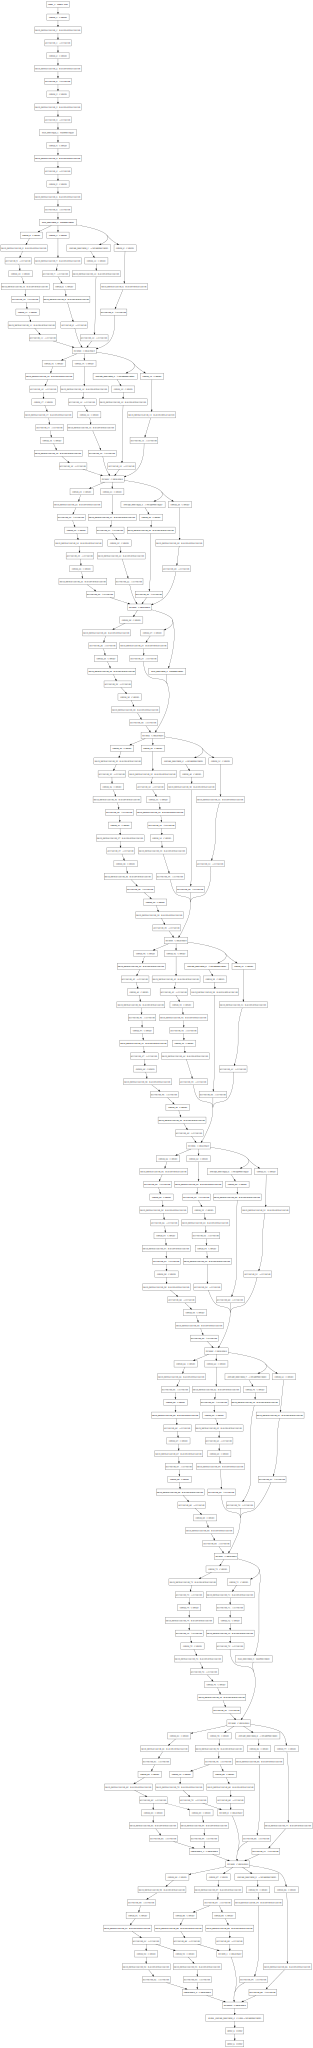

In [21]:
plot_model(model, to_file='model.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Data Generation and feed to NN

In [14]:
train_datagen = ImageDataGenerator(
#preprocessing_function=preprocess_input,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=10)

test_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=10)

print("Training Set : ")
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = label_mode)

print("Validation Set : ")
validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = label_mode)









Training Set : 
Found 1141 images belonging to 2 classes.
Validation Set : 
Found 88 images belonging to 2 classes.


### Test of the DataGenerator


Found 1141 images belonging to 2 classes.
(2, 250, 400, 3)


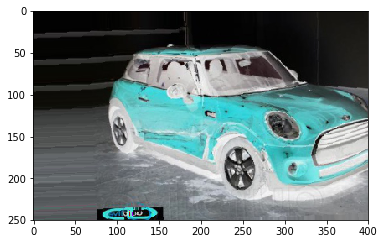

[ 1.  1.]


In [16]:
for X_batch, y_batch in train_datagen.flow_from_directory(train_data_dir,target_size = (img_height, img_width),batch_size = 2, class_mode = label_mode):
    print(X_batch.shape)
    #print(X_batch)
    plt.imshow(X_batch[0,:,:,:])
    # show the plot
    plt.show()
    print(y_batch)
    break


### Configure Callbacks and train model

In [10]:
# Model Callbacks  

#Saved every 2 epochs in this case
save_period=2
checkpoint = ModelCheckpoint("Inceptionv3_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=save_period)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Training : (Use Keras 2.0)
model.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples/batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size,
callbacks = [checkpoint, early])

Epoch 1/400
31/93 [========>.....................] - ETA: 4781s - loss: 0.7158 - acc: 0.6512

KeyboardInterrupt: 

$\alpha$